# Project 1 — Berry–Esseen Rate for Fixed Degree _d_

Empirical confirmation that the overlap  
$$
X_N := \sqrt{N}\,\langle q, u_2\rangle
$$
between a fixed test vector $q\perp\mathbf 1$ and the second eigenvector $u_2$ of a **random $d$-regular graph** converges to 𝒩(0, 1) at the **optimal Berry–Esseen rate**
$$
\sup_x \bigl|\mathbb P(X_N\le x)-\Phi(x)\bigr| \;=\; \Theta\!\bigl(N^{-1/6}\bigr),
$$
as established in Nagel (2025) and Huang–Yau (2023).

**Credits**: This notebook was written by [Hershraj Niranjani](https://hershrajn.com)

---

## Experimental Design

| Stage | What we do | Key parameters |
|-------|------------|----------------|
| **Graph generation** | Build $M \approx 1000$ simple $d$‑regular graphs for every size $N$. | $d \in \{3,5,10\};\; N \in \{5\,000, 10\,000, 20\,000, 40\,000\}$; `networkx.random_regular_graph` + rejection. |
| **Spectral step** | Form the normalised adjacency $\tilde A = A / \sqrt{d-1}$ and extract $u_2$. | `scipy.sparse.linalg.eigsh` (k = 2, which='LM'). |
| **Statistic** | Compute $X_N$ with $q = e_1 - \dfrac{1}{N}\mathbf 1$ (normalised). | Any deterministic $q \perp \mathbf 1$ works. |
| **Distance metric** | Kolmogorov–Smirnov distance $D_N = \sup_x \lvert F_N(x) - \Phi(x) \rvert$. | Use SciPy’s `stats.kstest` or a manual CDF grid. |
| **Rate extraction** | Linear regression of $\log D_N$ on $\log N$. | Slope $\approx -1/6$ corroborates theory. |


In [1]:
# Note: This was ran in a python virtual environment with python version 3.13.5
# Install the necessary dependencies
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import os 
from multiprocessing import cpu_count
from pathlib import Path
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import pickle
import re
import scipy.sparse.linalg as spla
from scipy.stats import kstest, norm
import pandas as pd

RANDOM_SEED = 42 # 42 for reproducibility

BASE = Path(os.path.abspath(''))

FIGURES = BASE / "figures"
FIGURES.mkdir(exist_ok=True) # Ensure that the figures directory exists

DATA = BASE / "data2"
DATA.mkdir(exist_ok=True) # Ensure that the data directory exists

GENERATE_GRAPH_DATA = True # If ./data has the graphs, set this to False to skip the long and tedious generation process
NUM_TO_GENERATE = 5000 # Number of graphs to generate per (n, d) configuration

d_selection: list[int] = [3, 5, 10]
n_selection: list[int] = [5_000, 10_000, 20_000, 40_000]


NUM_GRAPHS_TO_LOAD = 1000 # Number of graphs to load in per (n, d) configuration

print("Setup complete.")

/Users/hershraj.niranjani/Documents/GitHub/randomgraphs-universality-bounds/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete.


In [3]:
# Helper functions for graph file saving and loading

def save_graphs(graphs: list[nx.Graph], file_names: list[str], out_dir: str | Path) -> None:
    for graph, file_name in zip(graphs, file_names):
        file_path = Path(out_dir) / file_name
        with open(file_path, "wb") as f:
            pickle.dump(graph, f)

def load_graphs(file_names: list[str], in_dir: str | Path) -> list[nx.Graph]:
    graphs = []
    for file_name in file_names:
        file_path = Path(in_dir) / file_name
        with open(file_path, "rb") as f:
            graph = pickle.load(f)
            graphs.append(graph)
    return graphs

In [4]:
# Helped function to generate a random graph with a fixed degree
def _build_graph(n: int, d: int, seed: int) -> nx.Graph:
    """
    Build a single simple d-regular graph on n vertices using a fixed seed.
    Deterministic: same (n,d,seed) pair -> same graph.
    """
    return nx.random_regular_graph(d, n, seed=seed)

def generate_d_regular_graphs(
    d: int,
    n_list: list[int],
    *,
    samples_per_n: int = 1000,
    base_seed: int = RANDOM_SEED,
    chunk_size: int = 200,
    n_jobs: int | None = None,
    out_dir: str | Path | None = None
) -> dict[int, list[nx.Graph]]:
    """
    Generate `samples_per_n` simple d‑regular graphs for each n in `n_list`,
    reproducibly and in parallel.

    Parameters
    ----------
    d : int
        Degree of each vertex.
    n_list : list[int]
        Graph sizes to generate.
    samples_per_n : int, default 1000
        Number of graphs per size.
    base_seed : int, default 42
        Master seed ⇒ full reproducibility.
    chunk_size : int, default 100
        How many graphs a worker builds before we update the progress bar.
    n_jobs : int or None
        Parallel workers (defaults to all CPU cores).
    out_dir : str | Path or None
        If given, pickles each list of graphs to this directory.

    Returns
    -------
    dict[int, list[nx.Graph]]
        Mapping n → list of graphs (length = samples_per_n).
    """
    n_jobs = cpu_count() if n_jobs is None else n_jobs
    rng_global = np.random.default_rng(base_seed)
    out_dir = Path(out_dir) if out_dir else None
    if out_dir:
        out_dir.mkdir(parents=True, exist_ok=True)

    results: dict[int, list[nx.Graph]] = {}

    for n in n_list:
        # Pre‑allocate deterministic per‑graph seeds
        seeds = rng_global.integers(0, 2**32 - 1, size=samples_per_n, dtype=np.uint32)

        graphs_n: list[nx.Graph] = []
        with tqdm(total=samples_per_n, desc=f"d={d}, n={n}", unit="graph") as pbar:
            # Chunk the work to keep the progress bar smooth
            for start in range(0, samples_per_n, chunk_size):
                stop = min(start + chunk_size, samples_per_n)
                chunk_seeds = seeds[start:stop]

                chunk_graphs = Parallel(n_jobs=n_jobs, backend="loky")(
                    delayed(_build_graph)(n=n, d=d, seed=int(s)) for s in chunk_seeds
                )
                graphs_n.extend(chunk_graphs)
                pbar.update(len(chunk_graphs))

        results[n] = graphs_n

        if out_dir:
            # Save the graphs to files
            file_names = [f"graph_d{d}_n{n}_{i}.pkl" for i in range(samples_per_n)]
            save_graphs(graphs_n, file_names, out_dir)
            
    return results

In [ ]:
# Generate the graphs if they don't already exist
if not GENERATE_GRAPH_DATA:
    print("Graphs already generated. Skipping generation step.")
else:
    print("Generating graphs...")
    print("Warning: This may take a long while to run (> 3 hours), depending on the d and n values selected.")

    for d in tqdm(d_selection, desc="Generating 1000 d-regular graphs"):
        out_dir = DATA / f"d{d}"
        out_dir.mkdir(parents=True, exist_ok=True)
        results = generate_d_regular_graphs(
            d=d,
            n_list=n_selection,
            samples_per_n=NUM_TO_GENERATE,
            base_seed=RANDOM_SEED,
            chunk_size=200,
            n_jobs=None,
            out_dir=out_dir
        )

        print(f"Generation complete for d={d}. Graphs saved to: ", out_dir)

Generating graphs...


d=3, n=10000: 100%|██████████| 5000/5000 [02:38<00:00, 31.55graph/s]


In [ ]:
graph_files = (
      list((DATA / "d3").glob("*.pkl"))
    + list((DATA / "d5").glob("*.pkl"))
    + list((DATA / "d10").glob("*.pkl"))
)

pat_n = re.compile(r"_n(\d+)")
graphs_by_cfg: dict[tuple[int, int], list[Path]] = {}

for p in graph_files:
    try:
        d = int(p.parent.name[1:])          # folder “d3” → 3
    except ValueError:
        raise ValueError(f"Folder name {p.parent.name} must look like 'd3', 'd5', …")

    m = pat_n.search(p.stem)
    if m is None:
        raise ValueError(f"Cannot parse n from filename {p.name}")
    n = int(m.group(1))

    graphs_by_cfg.setdefault((n, d), []).append(p)

loaded_graphs: dict[tuple[int, int], list["nx.Graph"]] = {}

for (n, d), paths in graphs_by_cfg.items():
    selected = paths[:NUM_GRAPHS_TO_LOAD]          # deterministic order
    graphs = []
    for p in tqdm(selected, desc=f"n={n}, d={d}", unit="graph"):
        with open(p, "rb") as f:
            graphs.append(pickle.load(f))
    loaded_graphs[(n, d)] = graphs

for (n, d), g_list in loaded_graphs.items():
    print(f"Loaded {len(g_list):4d} graphs for n={n}, d={d}")

n=20000, d=3:  71%|███████   | 707/1000 [00:31<00:03, 82.37graph/s]

In [ ]:
# Helped function to compute the Berry-Esseen rate for a single graph
def _x_stat(graph: nx.Graph, q: np.ndarray) -> float:
    """
    Compute X_N = sqrt(N) * <q, u2> for one graph.
    q must be L2-normalised and orthogonal to 1.
    """
    n = graph.number_of_nodes()
    d = int(2 * graph.number_of_edges() / n)

    # sparse adjacency, normalised
    A = nx.to_scipy_sparse_array(graph, dtype=float) / math.sqrt(d - 1)

    # second largest eigenpair
    # eigsh returns eigenvalues ASC by default → ask for the top two (LM),
    # then take the second column.
    vals, vecs = spla.eigsh(A, k=2, which="LM", tol=1e-2)
    idx_u2 = np.argmax(vals) ^ 1        # toggles between 0 and 1
    u2 = vecs[:, idx_u2]

    return math.sqrt(n) * float(q @ u2)

In [ ]:
# Compute q for every graph in the loaded graphs
q_by_n = {}
for n, _ in loaded_graphs.keys():
    e1 = np.zeros(n)
    e1[0] = 1.0
    q = e1 - 1.0 / n                     # orthogonal to 1
    q /= np.linalg.norm(q)
    q_by_n[n] = q

# Collect X_N statistics for each (n, d) configuration
rows = []
n_jobs = max(cpu_count() - 1, 1)

for (n, d), graphs in loaded_graphs.items():
    q = q_by_n[n]

    X_vals = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(_x_stat)(g, q) for g in tqdm(graphs, desc=f"n={n}, d={d}", unit="graph")
    )

    # Kolmogorov–Smirnov distance vs N(0,1)
    D_n, _ = kstest(X_vals, norm.cdf)

    rows.append(dict(n=n, d=d, D_n=D_n, n_graphs=len(X_vals)))

print("Computed D_n for all (n, d) configurations.")

# tidy DF: one row per (n,d)
res_df = pd.DataFrame(rows)

n=5000, d=10: 100%|██████████| 500/500 [00:08<00:00, 61.31graph/s]


Computed D_n for all (n, d) configurations.


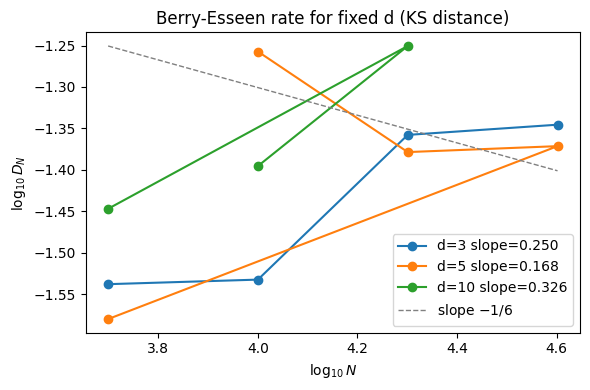

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(6, 4))

for d, sub in res_df.groupby("d"):
    xs = np.log10(sub["n"])
    ys = np.log10(sub["D_n"])
    # least‑squares slope
    m, b = np.polyfit(xs, ys, 1)
    ax.plot(xs, ys, "o-", label=fr"d={d} slope={m:.3f}")

# N^{-1/6} reference line (slope = –0.166…)
ref_x = np.array([res_df["n"].min(), res_df["n"].max()])
ref_y = np.log10(res_df["D_n"].max()) - (1/6) * (np.log10(ref_x) - np.log10(ref_x[0]))
ax.plot(np.log10(ref_x), ref_y, "--", color="gray", lw=1, label=r"slope $-1/6$")

ax.set_xlabel(r"$\log_{10} N$")
ax.set_ylabel(r"$\log_{10} D_N$")
ax.set_title("Berry-Esseen rate for fixed d (KS distance)")
ax.legend()
plt.tight_layout()
plt.show()